In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Notes
Data Exploration:
- Electricity demand is for NSW
- Temperature is for just Bankstown
- Different time spacings between electricity demand and temperature

Forecasting analysis:
- Clear trend between temperature and forecasting inaccuracy
    - Observed in both actual error and relative error
    - Inaccuracy is greater at extremely hot temperatures

In [2]:
df_temperature = pd.read_csv('data/temperature_nsw.csv', names = ['location', 'date_time', 'temperature'], skiprows = 1)
df_temperature.date_time = pd.to_datetime(df_temperature.date_time, format = "%d/%m/%Y %H:%M")

df_demand = pd.read_csv('data/totaldemand_nsw.csv', names = ['date_time', 'total_demand', 'region_id'], skiprows = 1)
df_demand.date_time = pd.to_datetime(df_demand.date_time, format = "%d/%m/%Y %H:%M")

df_forecast = pd.read_csv('data/forecastdemand_nsw.csv', names = ['id', 'region_id', 'period_id', 'forecast_demand', 'date_time_forecast', 'date_time_prediction'], skiprows = 1)
df_forecast.date_time_forecast = pd.to_datetime(df_forecast.date_time_forecast, format = "%Y-%m-%d %H:%M:%S")
df_forecast.date_time_prediction = pd.to_datetime(df_forecast.date_time_prediction, format = "%Y-%m-%d %H:%M:%S")

In [3]:
# Exploration - Temperature Dataset
print("Locations = {}".format(set(df_temperature.location)))
print("Date Min = {}  |  Date Max = {}".format(df_temperature.date_time.min(), df_temperature.date_time.max()))
print("Temp Min = {}  |  Temp Max = {}\n".format(df_temperature.temperature.min(), df_temperature.temperature.max()))
print(df_temperature.head())
print("\nRows = {}".format(len(df_temperature)))

Locations = {'Bankstown'}
Date Min = 2010-01-01 00:00:00  |  Date Max = 2021-03-18 00:00:00
Temp Min = -1.3  |  Temp Max = 44.7

    location           date_time  temperature
0  Bankstown 2010-01-01 00:00:00         23.1
1  Bankstown 2010-01-01 00:01:00         23.1
2  Bankstown 2010-01-01 00:30:00         22.9
3  Bankstown 2010-01-01 00:50:00         22.7
4  Bankstown 2010-01-01 01:00:00         22.6

Rows = 220326


In [4]:
# Exploration - Demand Dataset
print("Regions = {}".format(set(df_demand.region_id)))
print("Date Min = {}  |  Date Max = {}".format(df_demand.date_time.min(), df_demand.date_time.max()))
print("Demand Min = {}  |  Demand Max = {}\n".format(df_demand.total_demand.min(), df_demand.total_demand.max()))
print(df_demand.head())
print("\nRows = {}".format(len(df_demand)))

Regions = {'NSW1'}
Date Min = 2010-01-01 00:00:00  |  Date Max = 2021-03-18 00:00:00
Demand Min = 5074.63  |  Demand Max = 14579.86

            date_time  total_demand region_id
0 2010-01-01 00:00:00       8038.00      NSW1
1 2010-01-01 00:30:00       7809.31      NSW1
2 2010-01-01 01:00:00       7483.69      NSW1
3 2010-01-01 01:30:00       7117.23      NSW1
4 2010-01-01 02:00:00       6812.03      NSW1

Rows = 196513


In [5]:
# Exploration - Forecast Dataset
print("Regions = {}".format(set(df_forecast.region_id)))
#print("Periods = {}".format(set(df_forecast.period_id)))
print("Forecast Date Min = {}  |  Forecast Date Max = {}".format(df_forecast.date_time_forecast.min(), df_forecast.date_time_forecast.max()))
print("Predict Date Min = {}  |  Predict Date Max = {}".format(df_forecast.date_time_prediction.min(), df_forecast.date_time_prediction.max()))
print("Forecast Demand Min = {}  |  Forecast Demand Max = {}\n".format(df_forecast.forecast_demand.min(), df_forecast.forecast_demand.max()))
print(df_forecast.head())
print("\nRows = {}".format(len(df_forecast)))

Regions = {'NSW1'}
Forecast Date Min = 2009-12-30 12:31:49  |  Forecast Date Max = 2021-03-17 23:31:33
Predict Date Min = 2010-01-01 00:00:00  |  Predict Date Max = 2021-03-18 00:00:00
Forecast Demand Min = 4422.46  |  Forecast Demand Max = 14736.66

           id region_id  period_id  forecast_demand  date_time_forecast  \
0  2009123018      NSW1         71          7832.04 2009-12-30 12:31:49   
1  2009123019      NSW1         70          7832.04 2009-12-30 13:01:43   
2  2009123020      NSW1         69          7832.03 2009-12-30 13:31:36   
3  2009123021      NSW1         68          7832.03 2009-12-30 14:01:44   
4  2009123022      NSW1         67          7830.96 2009-12-30 14:31:35   

  date_time_prediction  
0           2010-01-01  
1           2010-01-01  
2           2010-01-01  
3           2010-01-01  
4           2010-01-01  

Rows = 10906019


In [6]:
#Note: this code chunk may be slow to run
#Forecast_interval is the number of hours between prediction and it's forecast
interval = 60*60 #sets the interval in seconds
df_forecast["forecast_interval"] = df_forecast.date_time_prediction - df_forecast.date_time_forecast
df_forecast.forecast_interval = df_forecast.forecast_interval.apply(lambda x: x.total_seconds()/interval)

#Rounding forecast time to intervals of 30mins to match df_demand and only have one record where forecast interval is ~24hrs
interval_min, interval_max = 23 , 25 #sets a window for forecast periods
df_forecast_near24hour = df_forecast.loc[(df_forecast.forecast_interval > interval_min) & (df_forecast.forecast_interval < interval_max)]
df_forecast_near24hour["date_time_forecast_rounded"] = df_forecast_near24hour.date_time_forecast.apply(lambda x: x.round(freq='30min'))
df_forecast_near24hour_1instance = df_forecast_near24hour.loc[df_forecast_near24hour.groupby("date_time_forecast_rounded")["forecast_interval"].idxmax()]

#Merge forecast data with demand data
df_forecast_near24hour_1instance_with_demand = pd.merge(df_forecast_near24hour_1instance, df_demand, left_on = "date_time_forecast_rounded", right_on = "date_time")
df_forecast_near24hour_1instance_with_demand["forecast_error"] = df_forecast_near24hour_1instance_with_demand.total_demand - df_forecast_near24hour_1instance_with_demand.forecast_demand

C:\Users\Chamath\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


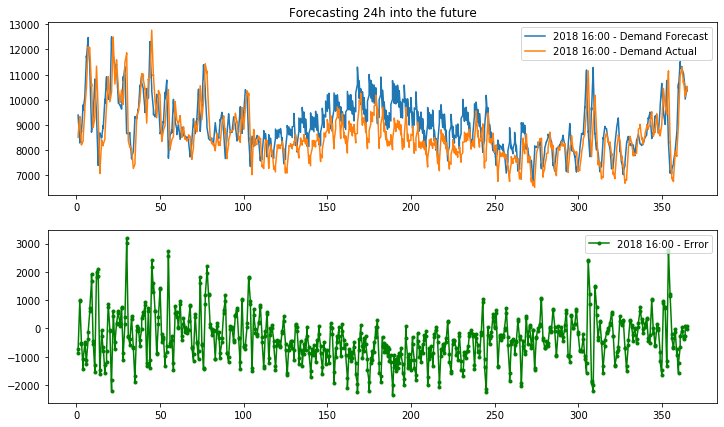

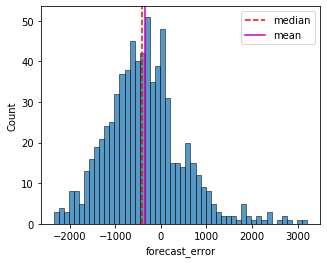

In [7]:
plot_year = 2018
plot_hour = 16

df_plot = df_forecast_near24hour_1instance_with_demand.loc[(df_forecast_near24hour_1instance_with_demand.date_time.dt.year == plot_year) & (df_forecast_near24hour_1instance_with_demand.date_time.dt.hour == plot_hour)]

plt.figure(figsize = (12,7))
plt.subplot(2,1,1)
plt.title("Forecasting 24h into the future")
plt.plot(df_plot.date_time.dt.dayofyear, df_plot.forecast_demand, label = '{} {}:00 - Demand Forecast'.format(plot_year, plot_hour))
plt.plot(df_plot.date_time.dt.dayofyear, df_plot.total_demand, label = '{} {}:00 - Demand Actual'.format(plot_year, plot_hour))
plt.legend(loc = 'upper right')

plt.subplot(2,1,2)
plt.plot(df_plot.date_time.dt.dayofyear, df_plot.forecast_error, 'g.-', label = '{} {}:00 - Error'.format(plot_year, plot_hour))
plt.legend(loc = 'upper right')

plt.figure(figsize = (5,4))
sns.histplot(df_plot.forecast_error, bins = 50);
plt.axvline(df_plot.forecast_error.median(), color='r', ls = '--', label = 'median')
plt.axvline(df_plot.forecast_error.mean(), color='m', label = 'mean')
plt.legend(loc = 'upper right')

Text(0, 0.5, 'Forecast Error as Portion of Actual Demand')

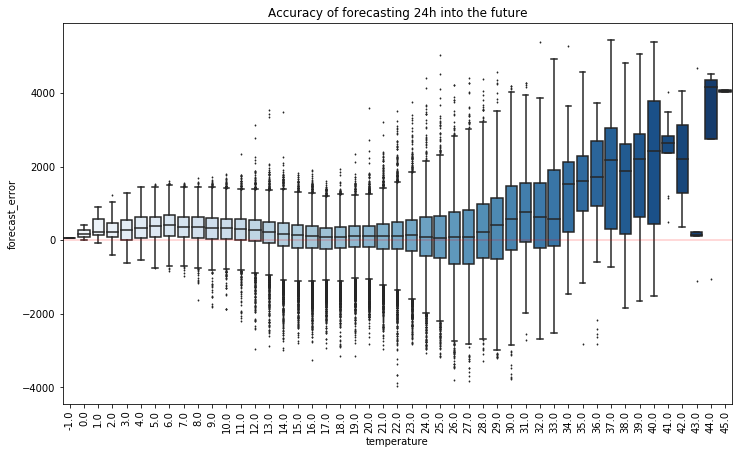

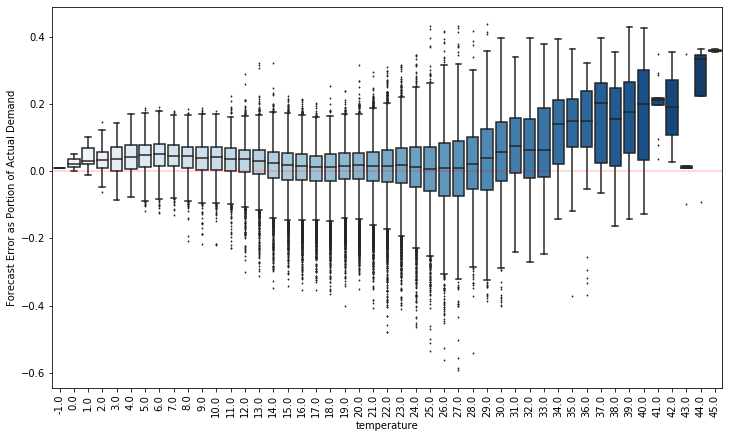

In [9]:
df_forecast_near24hour_1instance_with_demand_temperature = pd.merge(df_forecast_near24hour_1instance_with_demand, df_temperature, left_on = "date_time_forecast_rounded", right_on = "date_time")
df_forecast_near24hour_1instance_with_demand_temperature["forecast_error_relative"] = df_forecast_near24hour_1instance_with_demand_temperature.forecast_error/df_forecast_near24hour_1instance_with_demand_temperature.total_demand

df_plot = df_forecast_near24hour_1instance_with_demand_temperature[["temperature", "forecast_error", "forecast_error_relative"]].copy()
df_plot.temperature = df_plot.temperature.round()

plt.figure(figsize = (12,7))
sns.boxplot(data=df_plot, x="temperature", y="forecast_error", palette = 'Blues', fliersize = 1)
plt.axhline(0, color='r', alpha = 0.2)
plt.xticks(rotation = 90);
plt.title("Accuracy of forecasting 24h into the future")

plt.figure(figsize = (12,7))
sns.boxplot(data=df_plot, x="temperature", y="forecast_error_relative", palette = 'Blues', fliersize = 1)
plt.axhline(0, color='r', alpha = 0.2)
plt.xticks(rotation = 90);
plt.ylabel("Forecast Error as Portion of Actual Demand")